In [63]:


import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]



     


In [64]:


df = pd.read_csv("creditcard.csv")



     


In [65]:


df.isnull().values.any()



     


False

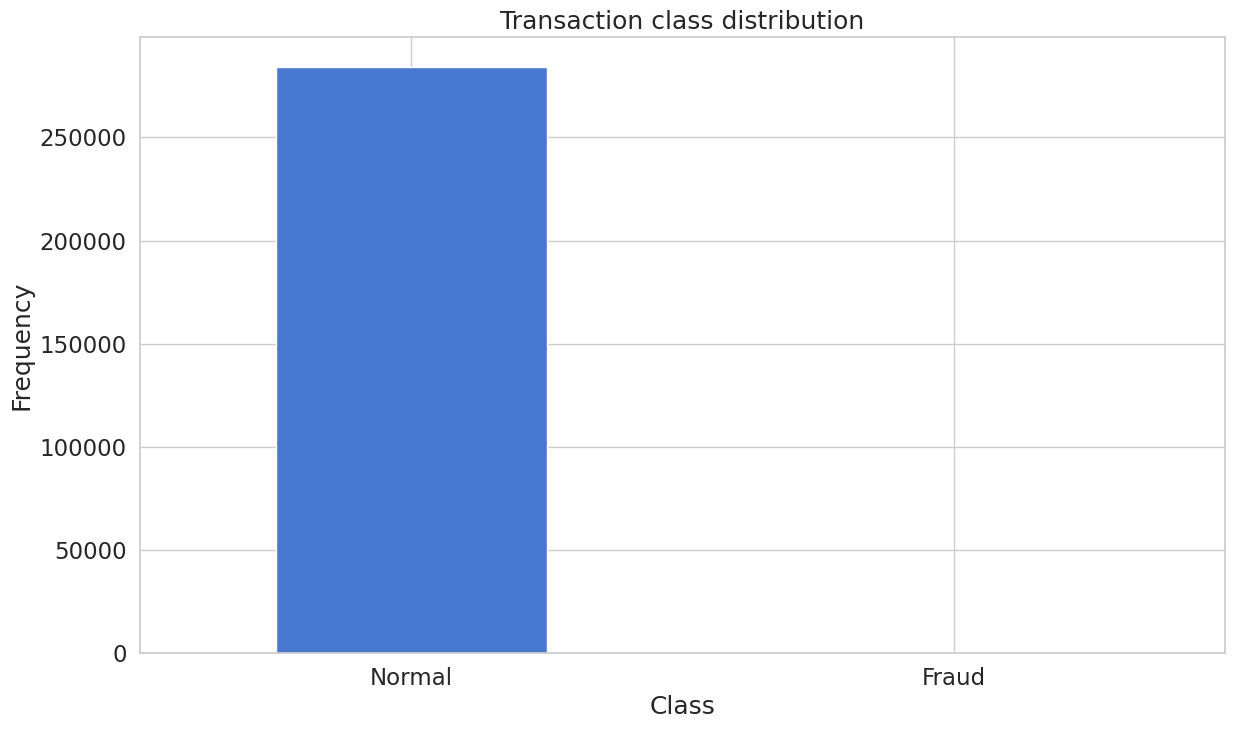

In [66]:


count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");



     


In [67]:


frauds = df[df.Class == 1]
normal = df[df.Class == 0]



     


frauds.shape



     


(492, 31)

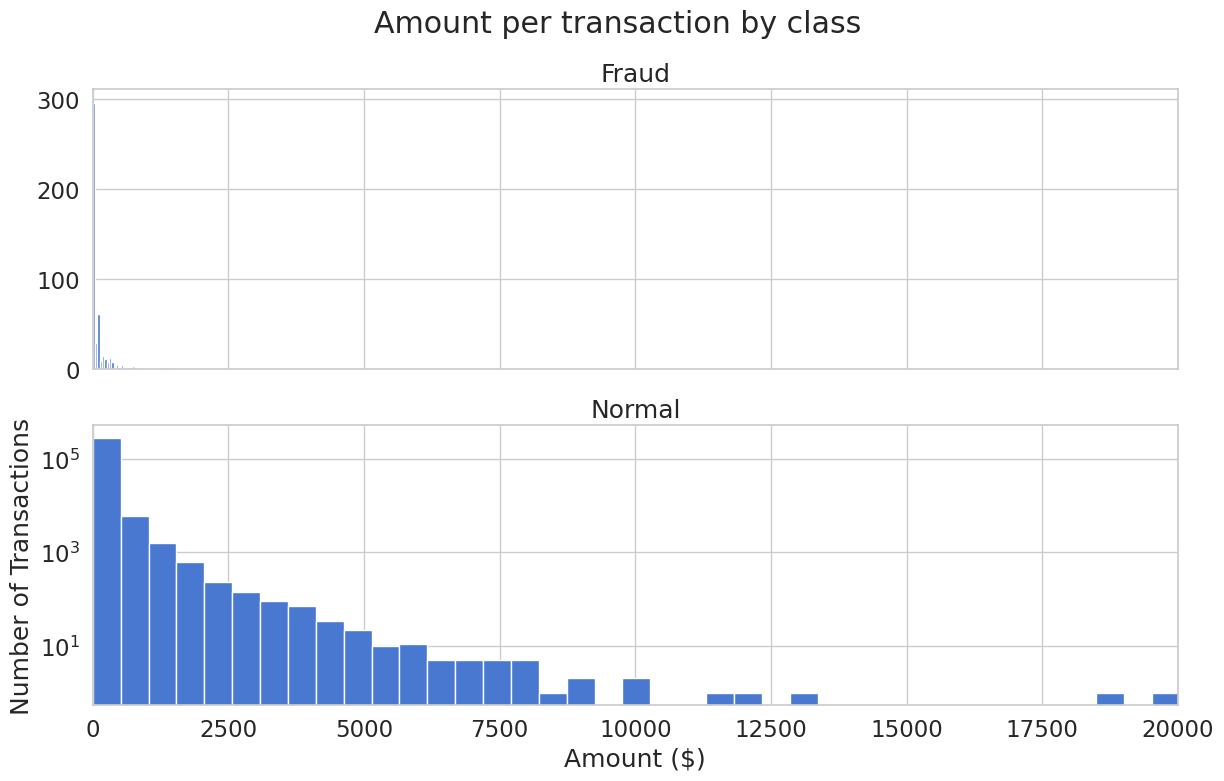

In [68]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

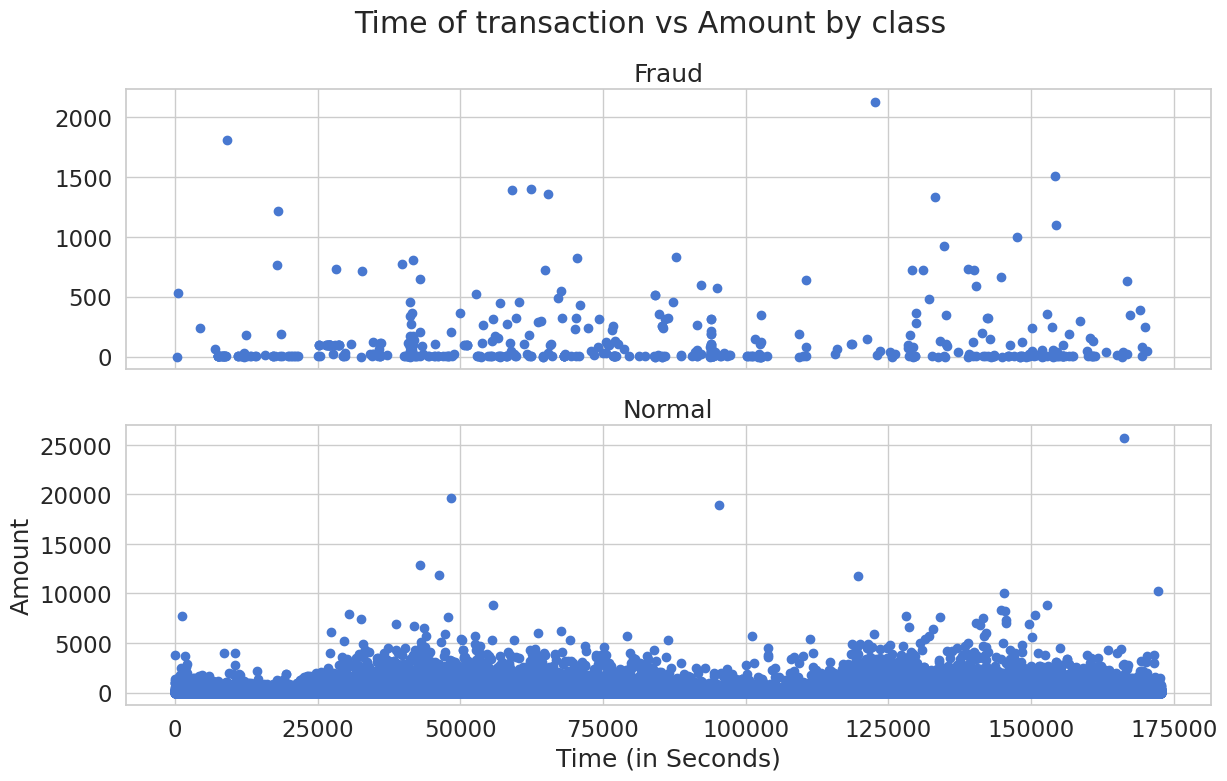

In [69]:


f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()



     


In [70]:


from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))



     


In [71]:


X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

X_train, X_final = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

y_final= X_final['Class']
X_final = X_final.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values
X_final = X_final.values



     


In [72]:


input_dim = X_train.shape[1]
encoding_dim = 14



     


In [73]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [74]:


nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history



     


Epoch 1/10
5686/5686 [==============================] - 10s 2ms/step - loss: 0.8307 - accuracy: 0.5480 - val_loss: 0.7890 - val_accuracy: 0.6544
Epoch 2/10
5686/5686 [==============================] - 9s 2ms/step - loss: 0.7423 - accuracy: 0.6676 - val_loss: 0.7582 - val_accuracy: 0.6722
Epoch 3/10
5686/5686 [==============================] - 9s 2ms/step - loss: 0.7268 - accuracy: 0.6736 - val_loss: 0.7487 - val_accuracy: 0.6790
Epoch 4/10
5686/5686 [==============================] - 9s 2ms/step - loss: 0.7197 - accuracy: 0.6841 - val_loss: 0.7438 - val_accuracy: 0.6932
Epoch 5/10
5686/5686 [==============================] - 9s 2ms/step - loss: 0.7159 - accuracy: 0.6901 - val_loss: 0.7426 - val_accuracy: 0.6943
Epoch 6/10
5686/5686 [==============================] - 9s 2ms/step - loss: 0.7136 - accuracy: 0.6926 - val_loss: 0.7397 - val_accuracy: 0.6946
Epoch 7/10
5686/5686 [==============================] - 9s 2ms/step - loss: 0.7120 - accuracy: 0.6955 - val_loss: 0.7388 - val_accuracy

In [75]:


autoencoder = load_model('model.h5')



     


evaluation

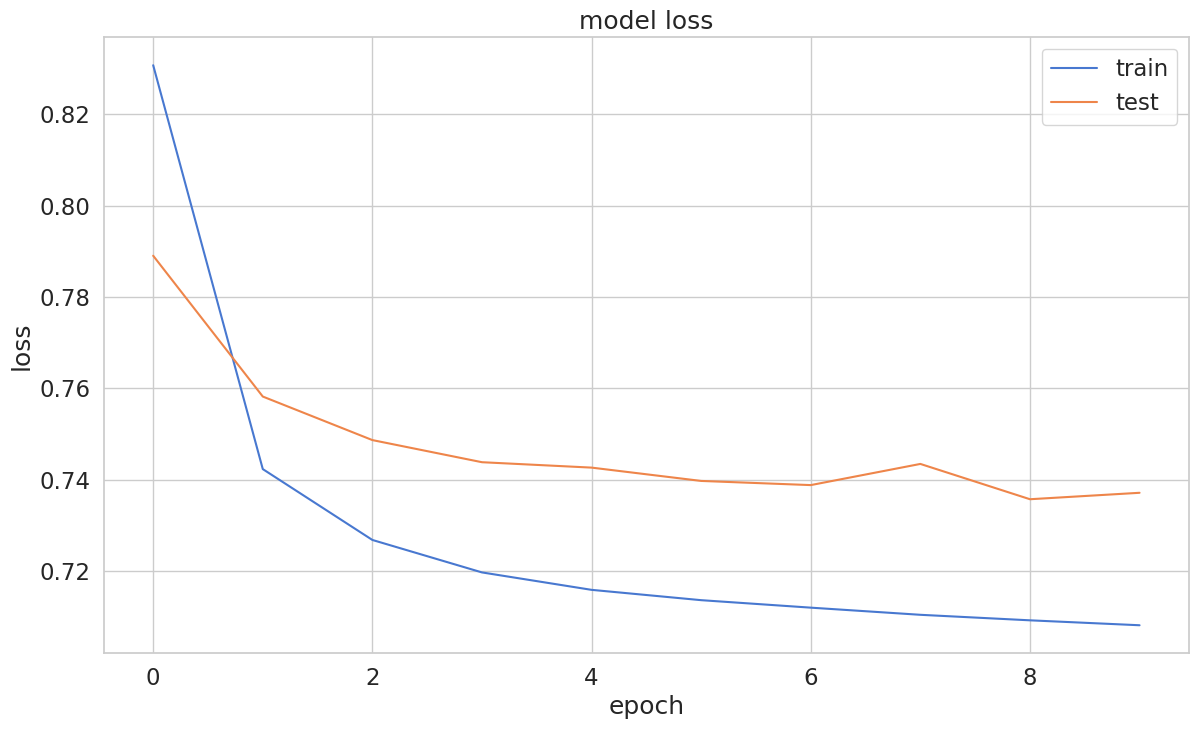

In [76]:


plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');



     


In [77]:


predictions = autoencoder.predict(X_test)



     


1781/1781 [==============================] - 2s 947us/step


In [78]:


mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})



     


In [79]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

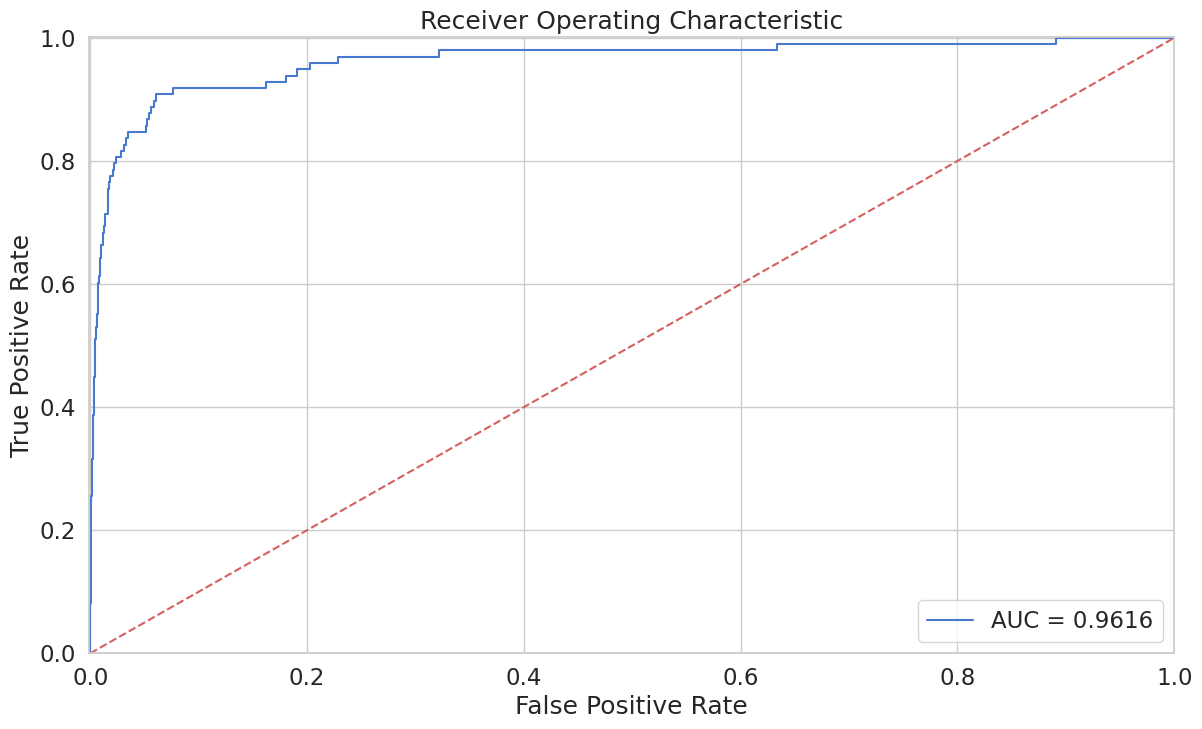

In [80]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

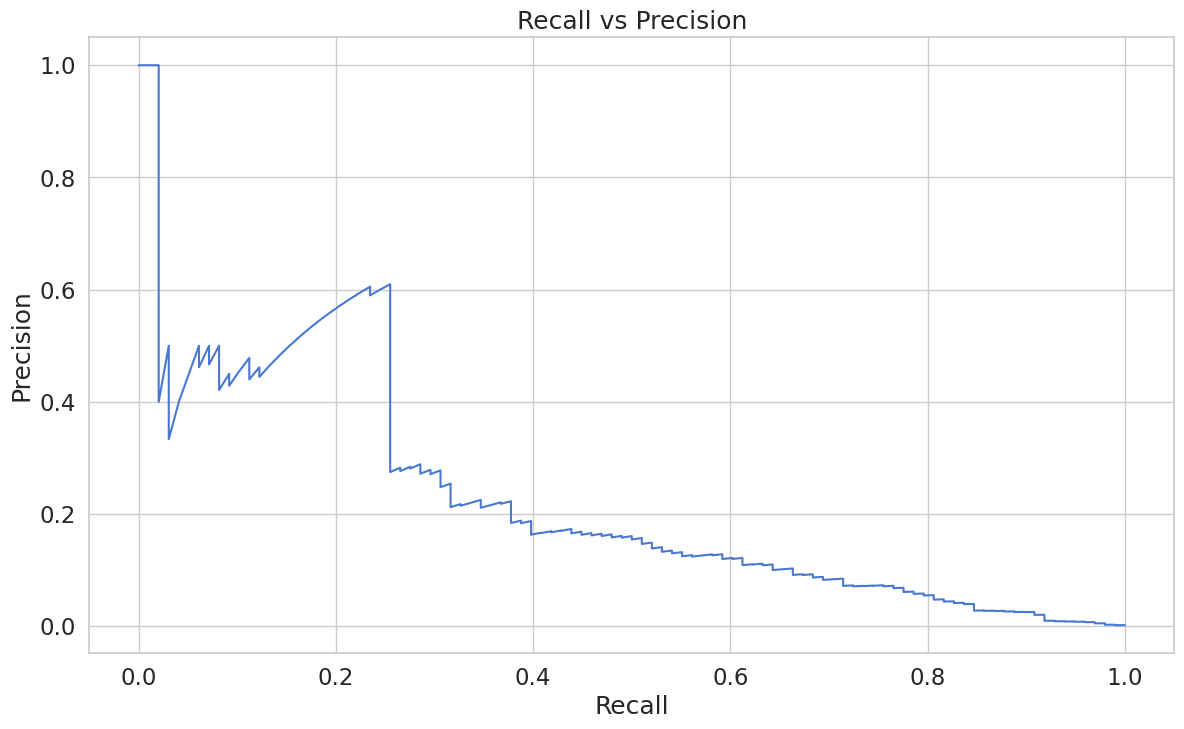

In [81]:


precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()



     


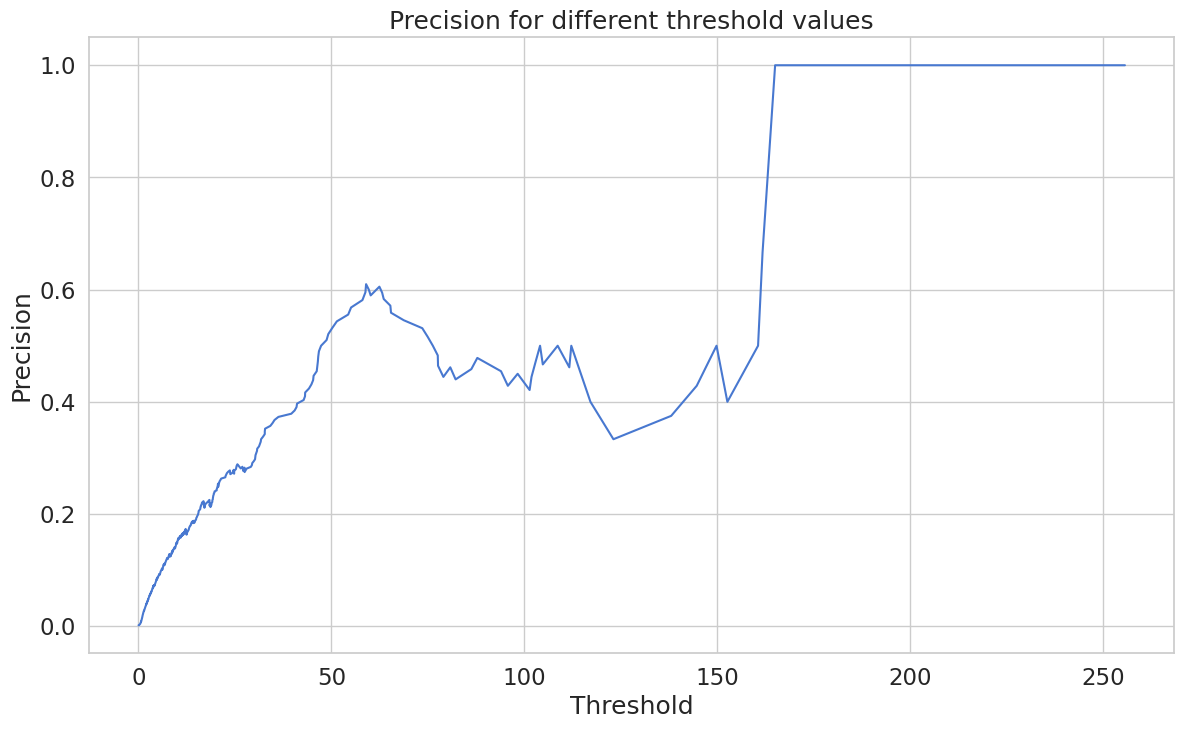

In [82]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

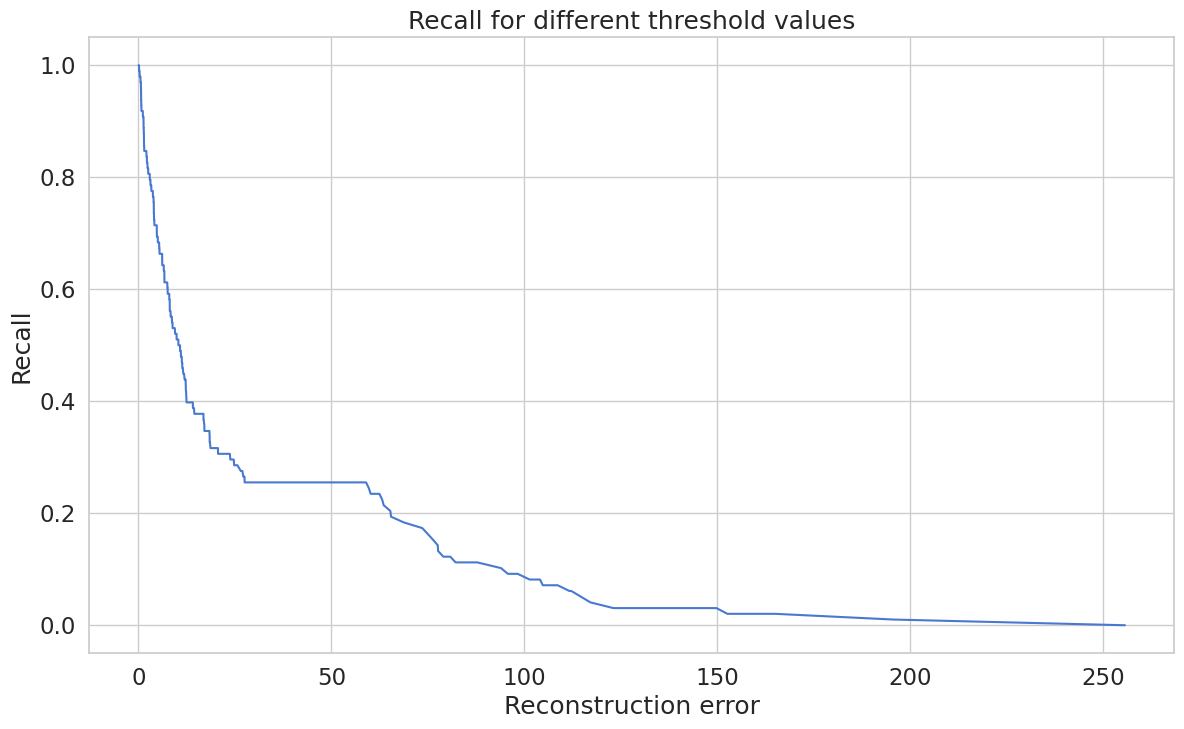

In [83]:


plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()



     


In [84]:


threshold = 2.9



     


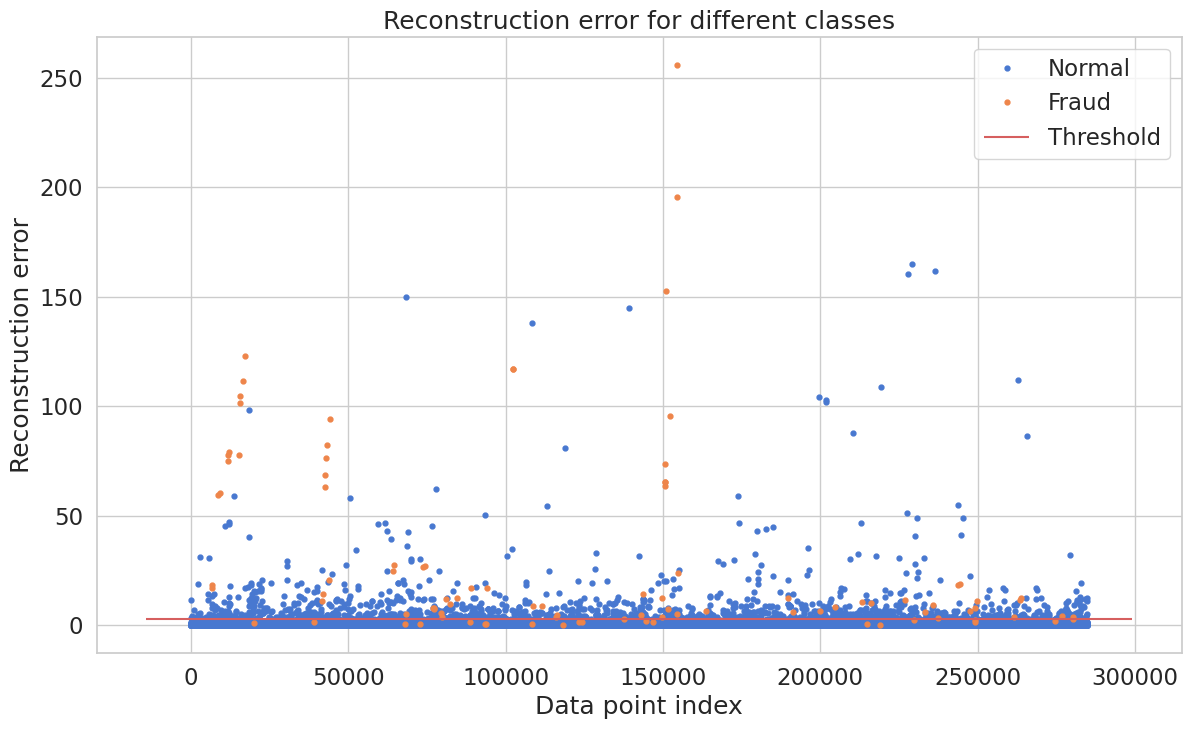

In [85]:


groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();



     


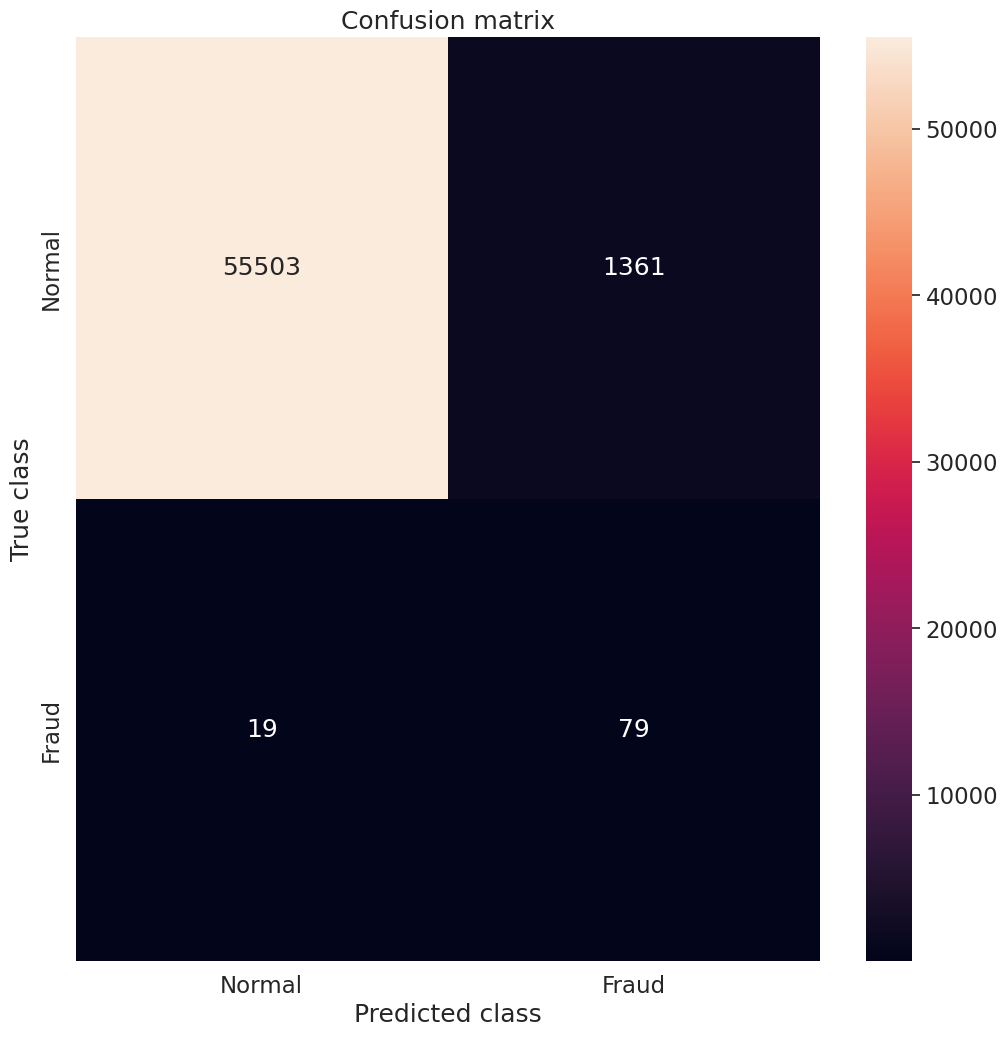

In [86]:


y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



     


In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [88]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.975773
Precision: 0.054861
Recall: 0.806122
F1 score: 0.102731


for comparison purpose

In [89]:
predictions_f = autoencoder.predict(X_final)


1425/1425 [==============================] - 1s 909us/step


In [90]:
mse_f = np.mean(np.power(X_final - predictions_f, 2), axis=1)
error_df_f = pd.DataFrame({'reconstruction_error': mse_f,
                        'true_class': y_final})

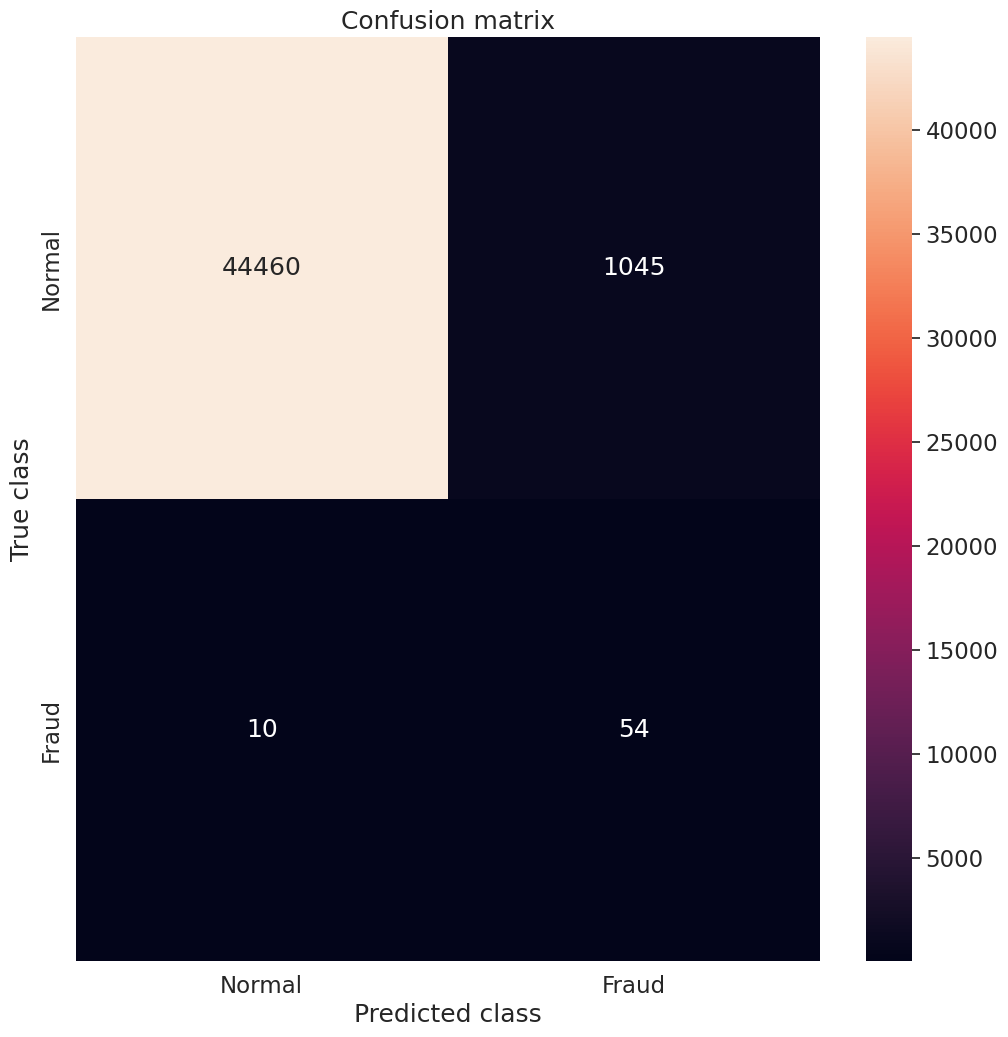

In [91]:
y_pred_f = [1 if e > threshold else 0 for e in error_df_f.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_f.true_class, y_pred_f)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [93]:
accuracy = accuracy_score(y_final, y_pred_f)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_final, y_pred_f)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_final, y_pred_f)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_final, y_pred_f)
print('F1 score: %f' % f1)

Accuracy: 0.976848
Precision: 0.049136
Recall: 0.843750
F1 score: 0.092863
